From the predicted chamber pressure, solves for the wall pressure distribution along the walls and throughout the chamber using Runge-Kutta FE analysis, to enable determination of pressure and heat on the walls for prediction of structural integrity 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Constants
gamma = 1.2
R = 287.0  # J/(kg·K)
min_rho = 1e-5
min_E = 1e-5
min_T = 10.0

# Simulation parameters
nx, ny = 64, 64
dx, dy = 0.01, 0.01
dt = 1e-6
nt = 1000

# Initial conditions
rho = np.ones((nx, ny)) * 1.2
u = np.zeros((nx, ny))
v = np.zeros((nx, ny))
T_field = np.ones((nx, ny)) * 300.0
E = rho * (T_field * R / (gamma - 1))
Y_fuel = np.ones((nx, ny)) * 0.05

In [3]:
# Place-holder: Predicted pressure function (chamber pressure input)
# to do: replace with LLM thrust curve time series inference
def predicted_pressure(t):
    return 2e6 * np.exp(-((t - 0.01) ** 2) / (2 * (0.003**2)))

In [4]:
# Sanitize fields to remove NaN, Inf, or complex parts
# To-do: relax sanitization in order to analyze instabilities 
# instabilities are more likely to cause failures including structural failures
def sanitize_field(field, name="var", min_val=1e-8):
    if np.iscomplexobj(field):
        print(f"[WARNING] Complex values detected in {name}, discarding imaginary part.")
        field = field.real
    if np.any(np.isnan(field)) or np.any(np.isinf(field)):
        print(f"[WARNING] NaN or Inf detected in {name}, replacing with min_val={min_val}")
        field = np.nan_to_num(field, nan=min_val, posinf=min_val, neginf=min_val)
    return np.clip(field, min_val, None)

In [5]:
# Compute combustion source term
def compute_combustion_source(Y_fuel, p, rho, R, gamma):
    burn_rate = 5e5 * Y_fuel * (p / 1e6)**0.5
    dT = burn_rate * 10.0  # Simple heat release
    Y_fuel_new = np.clip(Y_fuel - burn_rate * dt, 0.0, 1.0)
    return dT, Y_fuel_new

In [6]:
# Compute fluxes (finite difference Navier-Stokes core)
def compute_fluxes_all(rho, u, v, E):
    drho_dt = - (np.gradient(rho * u, dx, axis=0) + np.gradient(rho * v, dy, axis=1))
    du_dt = - u * np.gradient(u, dx, axis=0) - v * np.gradient(u, dy, axis=1)
    dv_dt = - u * np.gradient(v, dx, axis=0) - v * np.gradient(v, dy, axis=1)
    dE_dt = - u * np.gradient(E, dx, axis=0) - v * np.gradient(E, dy, axis=1)
    return drho_dt, du_dt, dv_dt, dE_dt

In [7]:
# RK4 integration
def rk4_step(rho, u, v, E, T_field, Y_fuel, t):
    def rhs(rho, u, v, E, T_field, Y_fuel, t):
        drho_dt, du_dt, dv_dt, dE_dt = compute_fluxes_all(rho, u, v, E)
        dT, Y_fuel_new = compute_combustion_source(Y_fuel, predicted_pressure(t), rho, R, gamma)
        dE_dt += rho * dT * R / (gamma - 1)
        return drho_dt, du_dt, dv_dt, dE_dt, dT, Y_fuel_new

    rho1, u1, v1, E1, T1, Y1 = rhs(rho, u, v, E, T_field, Y_fuel, t)
    rho2, u2, v2, E2, T2, Y2 = rhs(rho + 0.5*dt*rho1, u + 0.5*dt*u1, v + 0.5*dt*v1, E + 0.5*dt*E1, T_field + 0.5*dt*T1, Y1, t + 0.5*dt)
    rho3, u3, v3, E3, T3, Y3 = rhs(rho + 0.5*dt*rho2, u + 0.5*dt*u2, v + 0.5*dt*v2, E + 0.5*dt*E2, T_field + 0.5*dt*T2, Y2, t + 0.5*dt)
    rho4, u4, v4, E4, T4, Y4 = rhs(rho + dt*rho3, u + dt*u3, v + dt*v3, E + dt*E3, T_field + dt*T3, Y3, t + dt)

    rho += dt * (rho1 + 2*rho2 + 2*rho3 + rho4) / 6
    u += dt * (u1 + 2*u2 + 2*u3 + u4) / 6
    v += dt * (v1 + 2*v2 + 2*v3 + v4) / 6
    E += dt * (E1 + 2*E2 + 2*E3 + E4) / 6
    T_field += dt * (T1 + 2*T2 + 2*T3 + T4) / 6
    Y_fuel = Y4

    # Sanitize all fields
    rho = sanitize_field(rho, "rho", min_rho)
    u = sanitize_field(u, "u")
    v = sanitize_field(v, "v")
    E = sanitize_field(E, "E", min_E)
    T_field = sanitize_field(T_field, "T_field", min_T)
    Y_fuel = sanitize_field(Y_fuel, "Y_fuel", 0.0)

    return rho, u, v, E, T_field, Y_fuel

In [8]:
# Main simulation loop
times = []
probe_pressures = []

wall_pressure_history = []
for n in range(nt):
    
    t = n * dt
    p = (gamma - 1) * (E - 0.5 * rho * (u**2 + v**2))
    T_field = np.clip(p / (rho * R + 1e-8), min_T, None)

    # Sanitize
    p = sanitize_field(p, "p")
    T_field = sanitize_field(T_field, "T_field")

    wall_pressure_history.append(p[:, 0])  # bottom wall at j=0

    probe_pressures.append(p[nx//2, ny//2])
    times.append(t)

    rho, u, v, E, T_field, Y_fuel = rk4_step(rho, u, v, E, T_field, Y_fuel, t)

wall_pressure_history = np.array(wall_pressure_history)  # shape: (nt, nx)

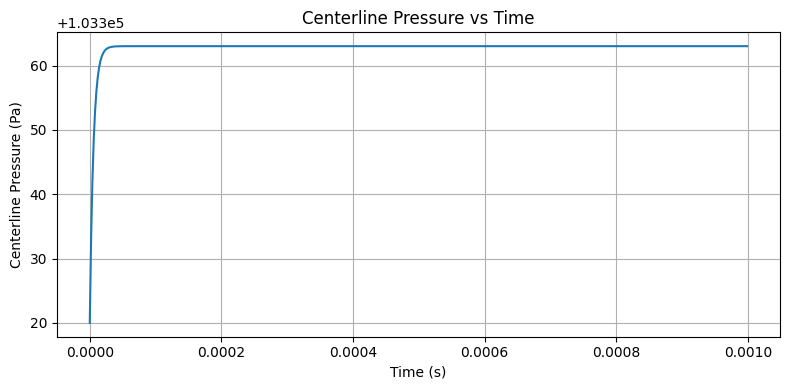

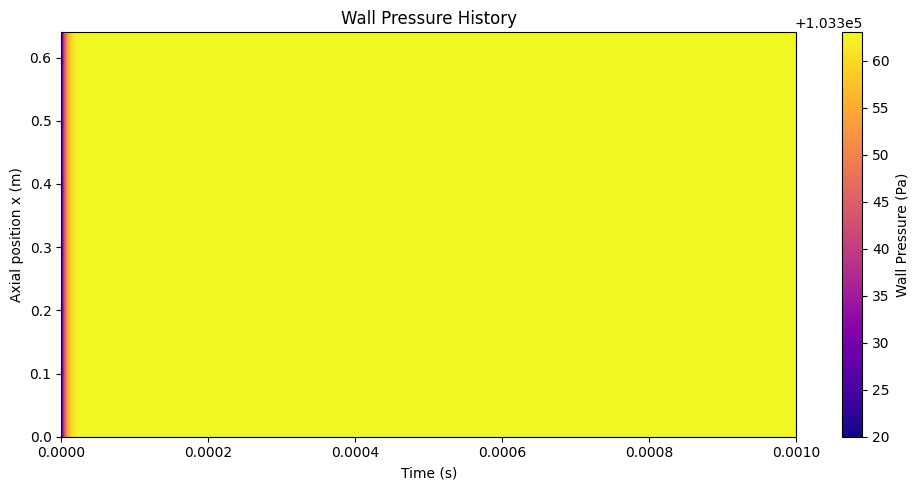

In [9]:
# Plot probe pressure
plt.figure(figsize=(8, 4))
plt.plot(times, probe_pressures)
plt.xlabel("Time (s)")
plt.ylabel("Centerline Pressure (Pa)")
plt.title("Centerline Pressure vs Time")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(wall_pressure_history.T, aspect='auto', origin='lower',
           extent=[0, nt*dt, 0, dx*nx], cmap='plasma')
plt.colorbar(label="Wall Pressure (Pa)")
plt.xlabel("Time (s)")
plt.ylabel("Axial position x (m)")
plt.title("Wall Pressure History")
plt.tight_layout()
plt.show()        